# Import Necessary Libraries

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune

from sklearn import metrics

import matplotlib.pyplot as plt

import copy

# Show 18 Images of MNIST Dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/Users/kiananvari/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


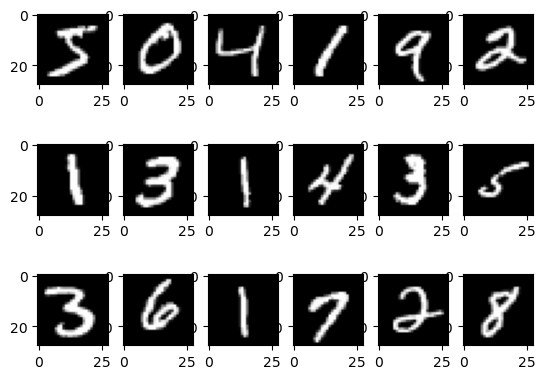

In [2]:
mnist_images = datasets.MNIST('data', train=True, download=True)

for k, (image, label) in enumerate(mnist_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap="gray")

# Split dataset images into train/validation images

In [6]:
mnist_data = datasets.MNIST('data', train=True, transform=transforms.ToTensor())

mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

# Class/Structure of fully-connected classifier model

In [7]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
#         input is 28*28 and we have 256 neurons in layer1

        self.layer1 = nn.Linear(28 * 28, 256)
    
#         freeze 15% of neurons to avoid over-fitting

        self.drop = nn.Dropout(0.15)
        self.layer2 = nn.Linear(256, 10)
        
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.sigmoid(self.layer1(flattened))
        drop1 = self.drop(activation1)
        output = self.layer2(drop1)
        return output


tensor([[-0.2993,  0.0415, -0.3139,  0.4649, -0.1052, -0.4542,  0.6010,  0.0272,
          0.6462,  0.1412]], grad_fn=<AddmmBackward>)
torch.Size([1, 10])


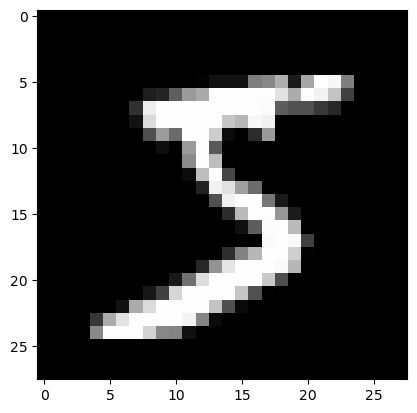

In [109]:
model = MNISTClassifier()
prob = F.softmax(output, dim=1)
first_img , first_label = mnist_train[0]
output = model(first_img)
plt.imshow(first_img[0], cmap="gray")
print(output)
print(output.shape)

# Define train function

In [80]:
import torch.optim as optim

def train(model, data, batch_size=32, num_epochs=1):
    
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    
    n = 0 
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()              
            optimizer.zero_grad()         

            iters.append(n)
            losses.append(float(loss)/batch_size)             
            train_acc.append(get_accuracy(model, train=True)) 
            val_acc.append(get_accuracy(model, train=False))  
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Define get accuracy function

In [10]:
train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=4096)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1024)

def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs) 
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
    return correct / total

# Train Model

In [ ]:
model = MNISTClassifier()

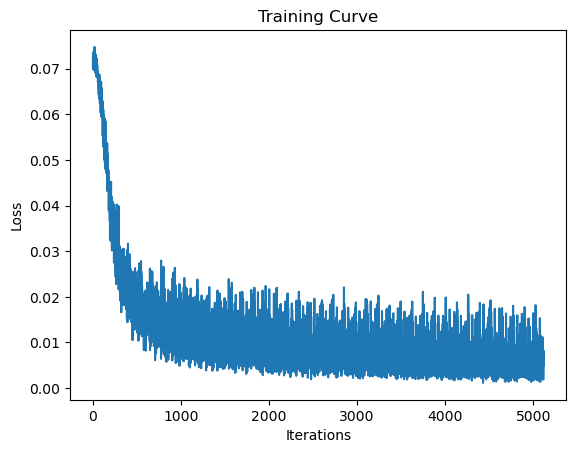

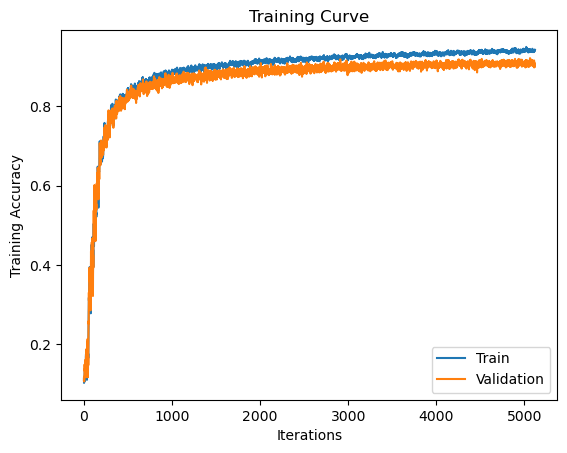

Final Training Accuracy: 0.943359375
Final Validation Accuracy: 0.904296875


In [10]:
train(model, mnist_train, num_epochs=40)

torch.save(model.state_dict(), "saved_model1")

# Evaluate Model

In [81]:
model = MNISTClassifier()
model.load_state_dict(torch.load('saved_model12'))
get_accuracy(model, train=False)

0.921875

# Random Weight Pruning For Compress Neural Networkk

In [98]:
accuracy = []

for i in range(10):
    
  model = MNISTClassifier()
  model.load_state_dict(torch.load('saved_model12'))
    
  prune.random_unstructured(model.layer1,name ='weight', amount=(i/10))
  prune.random_unstructured(model.layer2,name ='weight', amount=(i/10))
  
  get_accuracy(model, train=False)
  accuracy.append(get_accuracy(model, train=False))


x = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]

AUC = 0.6020996093750001


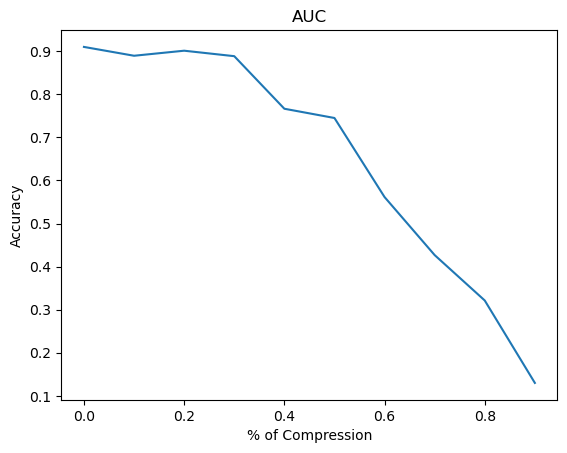

In [105]:
plt.subplot(1,1,1)
plt.title("AUC")
plt.xlabel("% of Compression")
plt.ylabel("Accuracy")
plt.plot(x, accuracy)

print(f"AUC = {metrics.auc(x, accuracy)}")

# Implementation of customized-pruning method

In [102]:
def fnd(arg, row):
    rr = int(arg/row)
    col = arg - (rr * row)
    return rr, col

In [107]:
accuracy1 = []

for i in range(10):
    
  model = MNISTClassifier()
  model.load_state_dict(torch.load('saved_model12'))
    
#   Map all weights into + area

  layer1 = torch.abs(copy.deepcopy(model.layer1.weight))
  layer2 = (copy.deepcopy(model.layer2.weight))
  
#   28 * 28 *256

  a = int((i/10)*200704)
    
#  256 * 10

  b = int((i/10)*2560)



  for _ in range(a):
        
#    find argmin(Minimum weight) in layer 1 in layer1 
    index = torch.argmin(layer1)
    
#    rows : number of neurons
    rr = model.layer1.weight.shape[1]
    
    row , col = fnd(index ,rr)
    
    with torch.no_grad():  
      layer1[row][col] = 5000
      model.layer1.weight[row][col] = 0


  
  for j_ in range(b):
    index=torch.argmin(layer2)
    rr = model.layer2.weight.shape[1]
    row , col = fnd(index ,rr )
    
    with torch.no_grad():  
      layer2[row][col]= 5000
      model.layer2.weight[row][col] = 0

        
  print(f"accuracy with {int((x[i])*100)}% compression is {get_accuracy(model, train=False)}")

  accuracy1.append(get_accuracy(model, train=False))


x = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]



accuracy with 0% compression is 0.919921875
accuracy with 10% compression is 0.8935546875
accuracy with 20% compression is 0.8681640625
accuracy with 30% compression is 0.859375
accuracy with 40% compression is 0.8720703125
accuracy with 50% compression is 0.8701171875
accuracy with 60% compression is 0.84765625
accuracy with 70% compression is 0.7939453125
accuracy with 80% compression is 0.7412109375
accuracy with 90% compression is 0.62890625


AUC = 0.74931640625


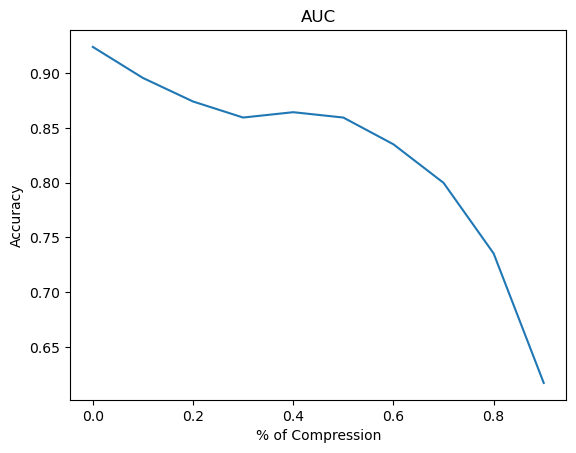

In [110]:
plt.subplot(1,1,1)
plt.title("AUC")
plt.xlabel("% of Compression")
plt.ylabel("Accuracy")
plt.plot(x, accuracy1)

print(f"AUC = {metrics.auc(x, accuracy1)}")